In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import catboost as cb
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
train.shape

(8523, 12)

In [4]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
train.Item_Identifier.value_counts()

Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

In [6]:
train['Item_Identifier_short'] = train['Item_Identifier'].apply(lambda x: x[0:2])

train['Item_Identifier_short'] = train['Item_Identifier_short'].map({'FD':'Food', 'NC':'Non_Consumable', 'DR':'Drinks'})

train['Item_Identifier_short'].value_counts()

Item_Identifier_short
Food              6125
Non_Consumable    1599
Drinks             799
Name: count, dtype: int64

In [7]:
train.Item_Weight.value_counts()

Item_Weight
12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: count, Length: 415, dtype: int64

In [8]:
train.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [9]:
# Corrrect the group names to avoid confusion.
# rename low fat, LF to Low Fat and reg to Regular
for i in range(0, train.shape[0]):
    if train.Item_Fat_Content.loc[i]=='LF' or train.Item_Fat_Content.loc[i]=='low fat':
        train.Item_Fat_Content.loc[i] = 'Low Fat'
    if train.Item_Fat_Content.loc[i]=='reg':
        train.Item_Fat_Content.loc[i] = 'Regular'
train.Item_Fat_Content.value_counts()

C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\1713746442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Item_Fat_Content.loc[i] = 'Low Fat'
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\1713746442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Item_Fat_Content.loc[i] = 'Low Fat'
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\1713746442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [10]:
train.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

In [11]:
train.Item_Visibility.value_counts()

Item_Visibility
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: count, Length: 7880, dtype: int64

In [12]:
train.Item_Visibility.describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

In [13]:
train.Item_Visibility[100]

0.063695084

### Item_Visibility cannot be zero. Lets impute zero values with mean value of the feature

In [15]:
mean_Item_Visibility =train.Item_Visibility.mean()
mean_Item_Visibility
for i in range(0, train.shape[0]):
    if train.Item_Visibility[i]==0:
        train.Item_Visibility[i] = mean_Item_Visibility
train.Item_Visibility.describe()        

C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\795369159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Item_Visibility[i] = mean_Item_Visibility
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\795369159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.Item_Visibility[i] = mean_Item_Visibility
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\795369159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

count    8523.000000
mean        0.070213
std         0.048742
min         0.003575
25%         0.033085
50%         0.062517
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

In [16]:
test.Item_Visibility.describe()  

count    5681.000000
mean        0.065684
std         0.051252
min         0.000000
25%         0.027047
50%         0.054154
75%         0.093463
max         0.323637
Name: Item_Visibility, dtype: float64

In [17]:
# Do the same for test data
mean_Item_Visibility_test = test.Item_Visibility.mean()

for i in range(0, test.shape[0]):
    if test.Item_Visibility[i]==0:
        test.Item_Visibility[i] = mean_Item_Visibility_test
test.Item_Visibility.describe()    

C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\3279813113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.Item_Visibility[i] = mean_Item_Visibility_test
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\3279813113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.Item_Visibility[i] = mean_Item_Visibility_test
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\3279813113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

count    5681.000000
mean        0.069765
std         0.048394
min         0.003591
25%         0.033208
50%         0.062137
75%         0.093463
max         0.323637
Name: Item_Visibility, dtype: float64

In [18]:
train.Item_Type.value_counts()

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

In [19]:
train.Item_MRP.value_counts()

Item_MRP
172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: count, Length: 5938, dtype: int64

In [20]:
train.Outlet_Identifier.value_counts()

Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64

In [21]:
train.Outlet_Establishment_Year.value_counts()

Outlet_Establishment_Year
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: count, dtype: int64

In [22]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
Item_Identifier_short         object
dtype: object

### Derive the age of the outlest based on establishment year

In [23]:
train['age_of_outlet']= train.Outlet_Establishment_Year.apply(lambda x: abs(x-2025))
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_short,age_of_outlet
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,16
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,26
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,Food,27
4,NCD19,8.93,Low Fat,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non_Consumable,38


In [70]:
train['age_of_outlet'].describe()

count    8523.000000
mean       27.168133
std         8.371760
min        16.000000
25%        21.000000
50%        26.000000
75%        38.000000
max        40.000000
Name: age_of_outlet, dtype: float64

In [71]:
train['age_of_outlet'].value_counts()

age_of_outlet
40    1463
38     932
26     930
28     930
21     930
23     929
16     928
18     926
27     555
Name: count, dtype: int64

In [24]:
train.Outlet_Size.value_counts()

Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

In [25]:
train.Outlet_Location_Type.value_counts()

Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64

In [26]:
train.Outlet_Type.value_counts()

Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64

In [72]:
train.isna().sum()

Item_Identifier          0
Item_Weight              0
Item_Fat_Content         0
Item_Visibility          0
Item_Type                0
Item_MRP                 0
Outlet_Identifier        0
Outlet_Size              0
Outlet_Location_Type     0
Outlet_Type              0
Item_Outlet_Sales        0
Item_Identifier_short    0
age_of_outlet            0
dtype: int64

In [28]:
train.Item_Weight.describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [30]:
# Fill the NA values with mean value of Item_Weight
train.Item_Weight.fillna(train.Item_Weight.mean(), inplace=True)

In [31]:
train.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_Identifier_short           0
age_of_outlet                   0
dtype: int64

In [32]:
train.Outlet_Size.describe()

count       6113
unique         3
top       Medium
freq        2793
Name: Outlet_Size, dtype: object

C:\Users\basavarajaiah.tm\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


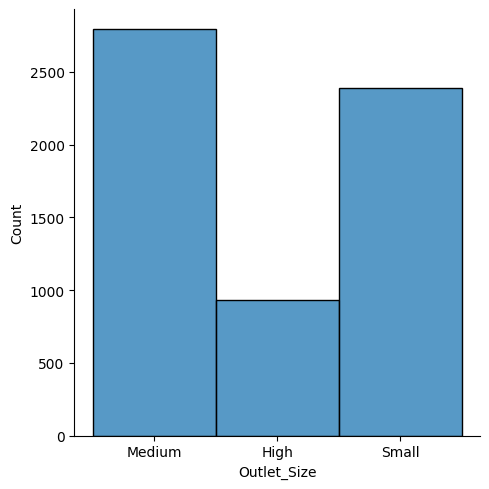

In [33]:
sns.displot(train, x="Outlet_Size")

In [34]:
# Impute the missing values with mode for Outlet_Size
train.Outlet_Size.fillna(train.Outlet_Size.mode()[0], inplace=True)

In [35]:
train.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Item_Identifier_short        0
age_of_outlet                0
dtype: int64

In [36]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
Item_Identifier_short         object
age_of_outlet                  int64
dtype: object

In [37]:
test.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [38]:
test['Item_Identifier_short'] = test['Item_Identifier'].apply(lambda x: x[0:2])

test['Item_Identifier_short'] = test['Item_Identifier_short'].map({'FD':'Food', 'NC':'Non_Consumable', 'DR':'Drinks'})

In [39]:
# Apply the same imputation for test data
# Fill the NA values with mean value of Item_Weight
test.Item_Weight.fillna(test.Item_Weight.mean(), inplace=True)
# Impute the missing values with mode for Outlet_Size
test.Outlet_Size.fillna(test.Outlet_Size.mode()[0], inplace=True)

In [40]:
test.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Identifier_short        0
dtype: int64

In [41]:
test['age_of_outlet']= test.Outlet_Establishment_Year.apply(lambda x: abs(x-2025))

In [42]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_short,age_of_outlet
0,FDW58,20.750000,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,Food,26
1,FDW14,8.300000,reg,0.038428,Dairy,87.3198,OUT017,2007,Medium,Tier 2,Supermarket Type1,Food,18
2,NCN55,14.600000,Low Fat,0.099575,Others,241.7538,OUT010,1998,Medium,Tier 3,Grocery Store,Non_Consumable,27
3,FDQ58,7.315000,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Medium,Tier 2,Supermarket Type1,Food,18
4,FDY38,12.695633,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,Food,40


In [44]:
col_drop = ['Outlet_Establishment_Year']

In [45]:
train.drop(col_drop, axis=1, inplace=True)
test.drop(col_drop, axis=1, inplace=True)

In [46]:
train.shape, test.shape

((8523, 13), (5681, 12))

In [47]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_short,age_of_outlet
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,Food,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,16
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,Food,26
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,Food,27
4,NCD19,8.93,Low Fat,0.066132,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,Non_Consumable,38


In [48]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_short,age_of_outlet
0,FDW58,20.750000,Low Fat,0.007565,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,Food,26
1,FDW14,8.300000,reg,0.038428,Dairy,87.3198,OUT017,Medium,Tier 2,Supermarket Type1,Food,18
2,NCN55,14.600000,Low Fat,0.099575,Others,241.7538,OUT010,Medium,Tier 3,Grocery Store,Non_Consumable,27
3,FDQ58,7.315000,Low Fat,0.015388,Snack Foods,155.0340,OUT017,Medium,Tier 2,Supermarket Type1,Food,18
4,FDY38,12.695633,Regular,0.118599,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,Food,40


In [49]:
test.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: count, dtype: int64

In [50]:
for i in range(0, test.shape[0]):
    if test.Item_Fat_Content.loc[i]=='LF' or test.Item_Fat_Content.loc[i]=='low fat':
        test.Item_Fat_Content.loc[i] = 'Low Fat'
    if test.Item_Fat_Content.loc[i]=='reg':
        test.Item_Fat_Content.loc[i] = 'Regular'

C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\2008489115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.Item_Fat_Content.loc[i] = 'Regular'
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\2008489115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.Item_Fat_Content.loc[i] = 'Low Fat'
C:\Users\basavarajaiah.tm\AppData\Local\Temp\ipykernel_28216\2008489115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [51]:
test.Item_Fat_Content.value_counts()

Item_Fat_Content
Low Fat    3668
Regular    2013
Name: count, dtype: int64

In [52]:
test.dtypes

Item_Identifier           object
Item_Weight              float64
Item_Fat_Content          object
Item_Visibility          float64
Item_Type                 object
Item_MRP                 float64
Outlet_Identifier         object
Outlet_Size               object
Outlet_Location_Type      object
Outlet_Type               object
Item_Identifier_short     object
age_of_outlet              int64
dtype: object

In [53]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Identifier_short',
       'age_of_outlet'],
      dtype='object')

In [54]:
ftrs = ['Item_Identifier_short','Item_Weight', 'Item_Fat_Content', 'Item_Visibility','Item_Type',
        'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'age_of_outlet']

In [55]:
cat_ftrs = [ 'Item_Identifier_short','Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type','Outlet_Size', 'Outlet_Type']

In [56]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_short,age_of_outlet
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,Food,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,16
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,Food,26
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,Food,27
4,NCD19,8.93,Low Fat,0.066132,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,Non_Consumable,38


In [57]:
y = train.Item_Outlet_Sales

In [58]:
X = train[ftrs]

In [59]:
X.head()

,Item_Identifier_short,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,age_of_outlet
0,Food,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,26
1,Drinks,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,16
2,Food,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,26
3,Food,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,Medium,Tier 3,Grocery Store,27
4,Non_Consumable,8.93,Low Fat,0.066132,Household,53.8614,High,Tier 3,Supermarket Type1,38


In [60]:
y

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

### Model training

In [54]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [55]:
# train_dataset = cb.Pool(X_train, y_train) 
# test_dataset = cb.Pool(X_test, y_test)

In [56]:
# model = cb.CatBoostRegressor(cat_features = cat_ftrs, loss_function='RMSE')

In [61]:
from sklearn.model_selection import RepeatedStratifiedKFold
# define models and parameters
model = cb.CatBoostRegressor(cat_features = cat_ftrs, loss_function='RMSE')
# n_estimators = [10, 100, 1000]
# max_depth=range(1,31)
# min_samples_leaf=np.linspace(0.1, 1.0)
# max_features=["auto", "sqrt", "log2"]
# min_samples_split=np.linspace(0.1, 1.0, 10)
# # define grid search
# grid = dict(n_estimators=n_estimators)
grid = {'iterations': [500,800,1000],
        'early_stopping_rounds':[10,20,30,40,50,100],
        'learning_rate': [0.01, 0.03,0.05,0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
grid_search_forest = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1,
scoring='r2',error_score=0,verbose=2,cv=2)
grid_search_forest.fit(X, y)
# summarize results
print(f"Best: {grid_search_forest.best_score_:.3f} using {grid_search_forest.best_params_}")
means = grid_search_forest.cv_results_['mean_test_score']
stds = grid_search_forest.cv_results_['std_test_score']
params = grid_search_forest.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.3f} ({stdev:.3f}) with: {param}")

Fitting 2 folds for each of 1152 candidates, totalling 2304 fits
0:	learn: 1697.2099901	total: 162ms	remaining: 2m 9s
1:	learn: 1688.1208634	total: 190ms	remaining: 1m 15s
2:	learn: 1679.8881101	total: 217ms	remaining: 57.7s
3:	learn: 1671.2193469	total: 246ms	remaining: 48.9s
4:	learn: 1662.4214345	total: 279ms	remaining: 44.4s
5:	learn: 1653.7644568	total: 307ms	remaining: 40.6s
6:	learn: 1645.3544861	total: 334ms	remaining: 37.8s
7:	learn: 1637.0150935	total: 362ms	remaining: 35.9s
8:	learn: 1628.6773350	total: 392ms	remaining: 34.5s
9:	learn: 1620.4796552	total: 420ms	remaining: 33.2s
10:	learn: 1612.2602283	total: 449ms	remaining: 32.2s
11:	learn: 1604.2068709	total: 479ms	remaining: 31.4s
12:	learn: 1596.5093879	total: 512ms	remaining: 31s
13:	learn: 1588.8545918	total: 542ms	remaining: 30.4s
14:	learn: 1581.2956000	total: 569ms	remaining: 29.8s
15:	learn: 1573.7563045	total: 597ms	remaining: 29.3s
16:	learn: 1566.3043187	total: 627ms	remaining: 28.9s
17:	learn: 1559.6916981	tota

In [62]:
print(f"Best: {grid_search_forest.best_score_:.3f} using {grid_search_forest.best_params_}")


Best: 0.602 using {'depth': 4, 'early_stopping_rounds': 10, 'iterations': 800, 'l2_leaf_reg': 0.2, 'learning_rate': 0.01}


In [125]:
Best: 0.602 using {'depth': 4, 'early_stopping_rounds': 10, 'iterations': 800, 'l2_leaf_reg': 0.2, 'learning_rate': 0.01}

In [63]:
best_model = cb.CatBoostRegressor(depth=4, early_stopping_rounds =10, iterations=800, l2_leaf_reg = 0.2, learning_rate= 0.01,cat_features = cat_ftrs, loss_function='RMSE')

In [64]:
best_model.fit(X,y)

0:	learn: 1697.2099901	total: 25.3ms	remaining: 20.2s
1:	learn: 1688.1208634	total: 53.8ms	remaining: 21.5s
2:	learn: 1679.8881101	total: 79ms	remaining: 21s
3:	learn: 1671.2193469	total: 103ms	remaining: 20.5s
4:	learn: 1662.4214345	total: 127ms	remaining: 20.2s
5:	learn: 1653.7644568	total: 156ms	remaining: 20.6s
6:	learn: 1645.3544861	total: 180ms	remaining: 20.4s
7:	learn: 1637.0150935	total: 203ms	remaining: 20.1s
8:	learn: 1628.6773350	total: 228ms	remaining: 20s
9:	learn: 1620.4796552	total: 253ms	remaining: 20s
10:	learn: 1612.2602283	total: 298ms	remaining: 21.4s
11:	learn: 1604.2068709	total: 334ms	remaining: 21.9s
12:	learn: 1596.5093879	total: 365ms	remaining: 22.1s
13:	learn: 1588.8545918	total: 392ms	remaining: 22s
14:	learn: 1581.2956000	total: 446ms	remaining: 23.3s
15:	learn: 1573.7563045	total: 483ms	remaining: 23.7s
16:	learn: 1566.3043187	total: 515ms	remaining: 23.7s
17:	learn: 1559.6916981	total: 545ms	remaining: 23.7s
18:	learn: 1552.4570209	total: 580ms	remainin

In [65]:
final_pred = best_model.predict(test[ftrs])
final_pred

array([1684.43167905, 1428.19582751,  681.73676218, ..., 1891.43218014,
       3578.0010945 , 1269.78135011])

In [66]:
test['Item_Outlet_Sales'] = final_pred
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Identifier_short,age_of_outlet,Item_Outlet_Sales
0,FDW58,20.750000,Low Fat,0.007565,Snack Foods,107.8622,OUT049,Medium,Tier 1,Supermarket Type1,Food,26,1684.431679
1,FDW14,8.300000,Regular,0.038428,Dairy,87.3198,OUT017,Medium,Tier 2,Supermarket Type1,Food,18,1428.195828
2,NCN55,14.600000,Low Fat,0.099575,Others,241.7538,OUT010,Medium,Tier 3,Grocery Store,Non_Consumable,27,681.736762
3,FDQ58,7.315000,Low Fat,0.015388,Snack Foods,155.0340,OUT017,Medium,Tier 2,Supermarket Type1,Food,18,2518.565521
4,FDY38,12.695633,Regular,0.118599,Dairy,234.2300,OUT027,Medium,Tier 3,Supermarket Type3,Food,40,6065.391587


In [67]:
test.Item_Outlet_Sales.describe()

count    5681.000000
mean     2188.603214
std      1309.605362
min        14.205942
25%      1141.854965
50%      2088.554413
75%      3112.700207
max      6217.977322
Name: Item_Outlet_Sales, dtype: float64

In [131]:
# test.Item_Outlet_Sales = test.Item_Outlet_Sales.apply(lambda x: 0 if x<0 else x)

In [132]:
test.Item_Outlet_Sales.describe()

count    5681.000000
mean     2188.799080
std      1307.849016
min        10.366945
25%      1134.583959
50%      2087.958104
75%      3114.188997
max      6203.225657
Name: Item_Outlet_Sales, dtype: float64

In [68]:
catboost_result = test[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
catboost_result

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1684.431679
1,FDW14,OUT017,1428.195828
2,NCN55,OUT010,681.736762
3,FDQ58,OUT017,2518.565521
4,FDY38,OUT027,6065.391587
...,...,...,...
5676,FDB58,OUT046,2255.011976
5677,FDD47,OUT018,2521.244720
5678,NCO17,OUT045,1891.432180
5679,FDJ26,OUT017,3578.001094


In [69]:
catboost_result.to_csv('catboost_result_new_ftr_V5_tuning.csv', index=False)